In [3]:
# 페이스북에서 만든 fbprophet 모듈
# 윈도우 visual c++ build tools 설치해야 함
# pip install pystan, pip install prophet, 
# prophet 설치가 안되면 conda install -c conda-forge fbprophet
# pip install pandas_datareader
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet
from datetime import datetime

In [4]:
# matplotlib 한글 문제 해결
path = 'c:/Windows/Fonts/malgun.ttf'
import platform
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('sorry')
    
plt.rcParams['axes.unicode_minus'] = False

In [6]:
# https://raw.githubusercontent.com/PinkWink/DataScience/master/data/08.%20PinkWink%20Web%20Traffic.csv
# csv 파일을 dataframe으로 읽기
# ,를 천 단위로 인식
# column name을 date, hit로 명명
# 첫번째 컬럼을 index로
# hit 데이터가 있는 것만 읽어들이기
pinkwink_web = pd.read_csv('./08. PinkWink Web Traffic.csv',
                          encoding='utf-8', thousands=',',
                          names=['date','hit'], index_col=0)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


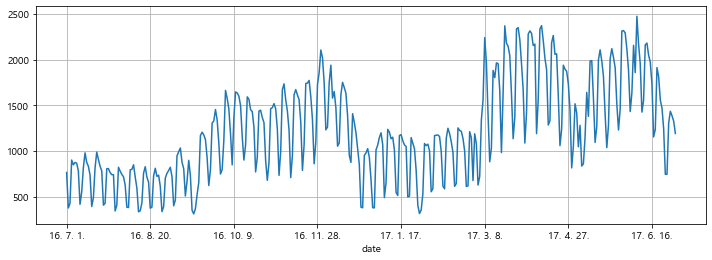

In [7]:
pinkwink_web['hit'].plot(figsize=(12,4), grid=True);

In [11]:
time = np.arange(0,len(pinkwink_web))
traffic = pinkwink_web['hit'].values # numpy array로 저장

fx = np.linspace(0, time[-1], 1000) # time을 1000개로 나누기

In [21]:
def error(f, x, y):
    return np.sqrt(np.mean((f(x)-y)**2)) # f라는 함수 정의는 나중에

In [23]:
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1) # fitting 함수의 계수

fp2 = np.polyfit(time, traffic, 2)
f2 = np.poly1d(fp2)

fp3 = np.polyfit(time, traffic, 3)
f3 = np.poly1d(fp3)

fp15 = np.polyfit(time, traffic, 15)
f15 = np.poly1d(fp15)

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

430.85973081109637
430.62841018946955
429.53280466762925
330.4777308491587


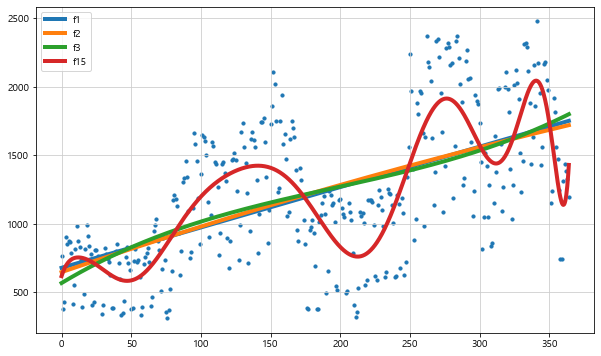

In [34]:
plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s=10) # scatter, size 10

plt.plot(fx, f1(fx), lw=4, label='f1') # linewidth -> lw
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.8') # color 1에 가까울수록 반투명
plt.legend(loc='best') # location, best
plt.show()